In [105]:
import keras
import tensorflow as tf

import numpy as np
from skimage import io
import random

from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard

import os
from importlib import reload

from stacked_mnist import StackedMNISTData, DataMode
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
from verification_net import *
from Classifier import * 

## Model Def

### Parameters

**dataset_seed** : Random seed for shuffling dataset  
**latent_dim** : Dimension of the latent space  
**train_prop** : Percentage for train (the rest being for the test) 
**batch_size** : Batch size  
**epochs** : Nb of epochs for training  
**fit_verbosity** is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch  

In [106]:
latent_dim       = 20
train_prop       = .8
batch_size       = 128
epochs           = 5
fit_verbosity    = 1

### Encoder

In [107]:

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(32, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()


### Decoder

In [108]:

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

## Auto Encoder Simple

In [109]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")
ae_anomally = keras.Model(inputs,outputs, name="ae_anomally")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')
ae_anomally.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

### Dataset

In [139]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_R = x_train[:, :, :, [0]]
x_test_R = x_test[:, :, :, [0]]



In [111]:
x_train_R.shape

(60000, 28, 28, 1)

### Training

In [112]:

history = ae.fit(x_train_R, x_train_R,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (x_test_R, x_test_R),
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - loss: 0.2781 - val_loss: 0.0989
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 114ms/step - loss: 0.0925 - val_loss: 0.0725
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 131ms/step - loss: 0.0711 - val_loss: 0.0637
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - loss: 0.0631 - val_loss: 0.0593
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - loss: 0.0580 - val_loss: 0.0555


Recup classifier entrainé    
Faire la prédiction des classes sur le jeu de données généré par l ae


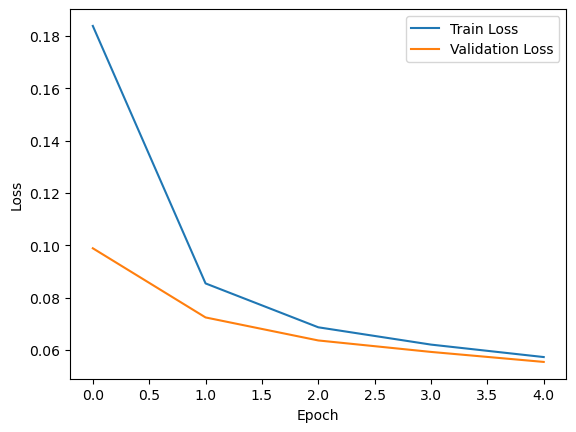

In [113]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predictions

In [140]:
no_channels = x_test.shape[-1]

data_gen = np.zeros(x_test.shape)
for channel in range(no_channels):
    data = ae.predict(x_test[:, :, :, [channel]])
    data_gen[:, :, :, channel] = data.squeeze()  # squeeze() to delete 1 dimension 

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [141]:
data_gen.shape #images generated by ae

(10000, 28, 28, 3)

In [142]:
predictions, beliefs = net.predict(data_gen)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [117]:
predictions


array([7., 2., 1., ..., 4., 5., 6.])

In [118]:
np.mean(predictions == y_test)

0.9404

In [143]:
net.check_predictability(data = data_gen, correct_labels=y_test, tolerance=0.8)
#returns predictability and accuracy : (x,y) : x where predictable with a belief > tolerance, and y accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


(0.7521, 0.7011)

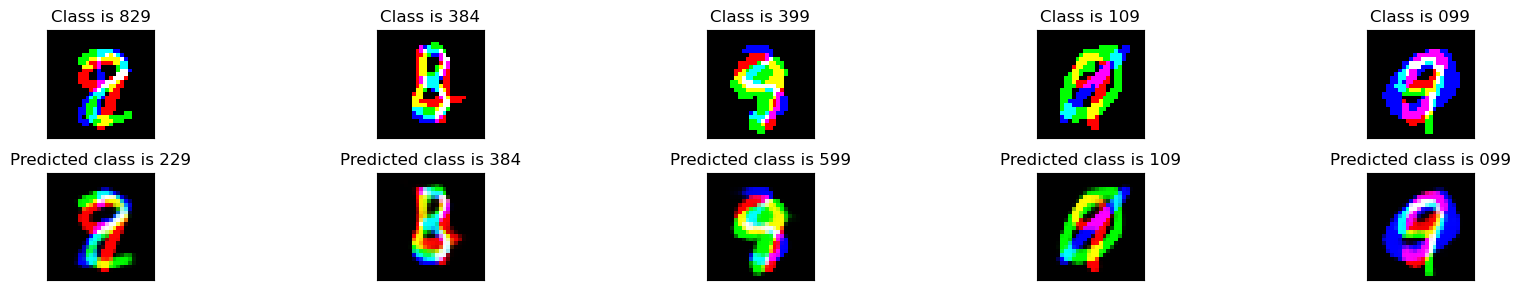

In [144]:
images = np.concatenate((x_test[:5], data_gen[:5]))
labels = np.concatenate((y_test[:5], predictions[:5]))

no_images = images.shape[0]

plt.figure(figsize=(18, 3))
no_rows = 2
no_cols = no_images//2
for img_idx in range(no_images):
    plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
    if x_test.shape[-1] == 1:
        plt.imshow(images[img_idx, :, :, 0], cmap="binary")
    else:
        plt.imshow(images[img_idx, :, :, :].astype(float))
    plt.xticks([])
    plt.yticks([])
    if img_idx < no_images//2:
        plt.title(f"Class is {str(int(labels[img_idx])).zfill(x_test.shape[-1])}")
    else : 
        plt.title(f"Predicted class is {str(int(labels[img_idx])).zfill(x_test.shape[-1])}")
# Show the thing ...
plt.tight_layout()
plt.show()

## Generative Model

First, let's study data distribution in the latent space

In [121]:
z = encoder.predict(x_train_R)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


In [122]:
z.shape

(60000, 20)

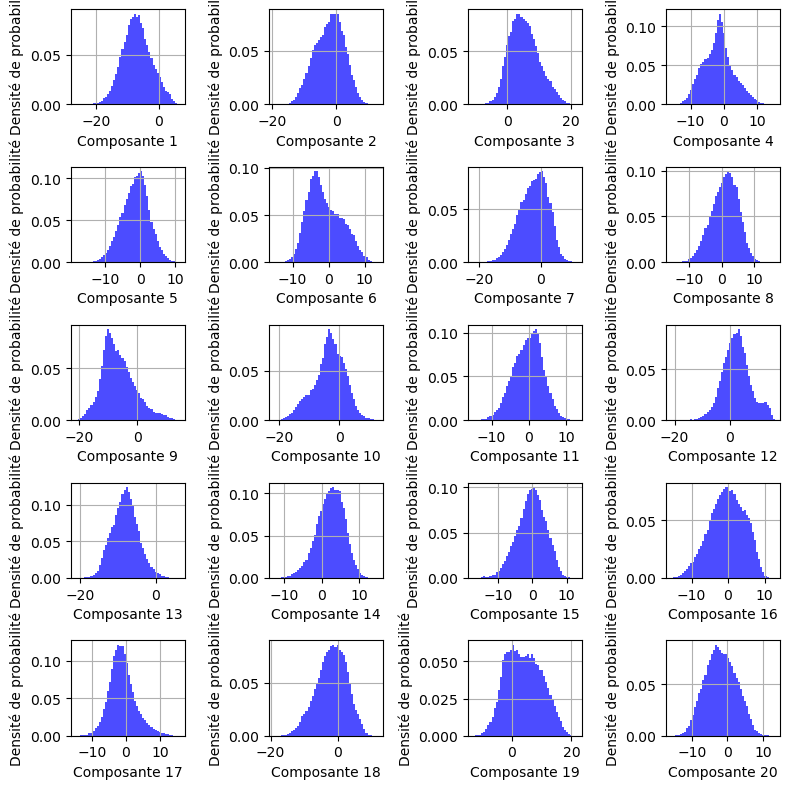

In [123]:
# Nombre de colonnes dans la matrice z
num_cols = z.shape[1]

# Création d'une figure avec un subplot 4x4
fig, axes = plt.subplots(latent_dim//4, 4, figsize=(8, 8))

# Boucle sur chaque composante et tracé de l'histogramme correspondant dans le subplot approprié
for i, ax in enumerate(axes.flatten()):
    ax.hist(z[:, i], bins=50, density=True, alpha=0.7, color='b')  # Tracé de l'histogramme
    ax.set_xlabel(f'Composante {i+1}')  # Étiquette de l'axe des x
    ax.set_ylabel('Densité de probabilité')  # Étiquette de l'axe des y
    ax.grid(True)  # Ajout de la grille

# Ajustement automatique de la disposition des subplots
plt.tight_layout()
plt.show()  # Affichage du graphique

In [124]:
#Close to normal distribution, let's calculate its parameter 
global_mean = 0
global_std = 0
for i in range(z.shape[1]):
    mean = np.mean(z[:,i])
    std = np.std(z[:,i])
    print(f'component {i} has mean = {mean} and std = {std}')
    global_mean += mean
    global_std += std

global_mean /= z.shape[1]
global_std /= z.shape[1]

print(f'global mean = {global_mean}, global_std = {global_std}')


component 0 has mean = -6.9650468826293945 and std = 4.520376205444336
component 1 has mean = -2.119647741317749 and std = 4.52726936340332
component 2 has mean = 5.3196702003479 and std = 4.605228900909424
component 3 has mean = -1.646104335784912 and std = 4.467315196990967
component 4 has mean = -1.3925641775131226 and std = 3.8461480140686035
component 5 has mean = -1.0406044721603394 and std = 4.611392021179199
component 6 has mean = -2.180931329727173 and std = 4.531495094299316
component 7 has mean = 0.9507907032966614 and std = 3.9774985313415527
component 8 has mean = -6.476675510406494 and std = 5.601263523101807
component 9 has mean = -3.304307222366333 and std = 5.125285625457764
component 10 has mean = -0.2136528640985489 and std = 3.8580987453460693
component 11 has mean = 2.486872673034668 and std = 5.00388240814209
component 12 has mean = -8.133049964904785 and std = 3.4543919563293457
component 13 has mean = 2.286078453063965 and std = 3.6173453330993652
component 14 h

Now let's generate our images

In [125]:
mode = 'MONO'

data_size = 9

random_vectors = np.random.randn(data_size, latent_dim)*global_std + global_mean



In [126]:
'''# Images Generation 

# Définir le modèle de décodeur seul
decoder_input = keras.Input(shape=(latent_dim,))
decoder_output = decoder(decoder_input)
generator = keras.Model(decoder_input, decoder_output, name="generator")

# Compiler le modèle génératif
generator.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

img_gen = generator.predict(random_vectors)'''

'# Images Generation \n\n# Définir le modèle de décodeur seul\ndecoder_input = keras.Input(shape=(latent_dim,))\ndecoder_output = decoder(decoder_input)\ngenerator = keras.Model(decoder_input, decoder_output, name="generator")\n\n# Compiler le modèle génératif\ngenerator.compile(optimizer=keras.optimizers.Adam(), loss=\'binary_crossentropy\')\n\nimg_gen = generator.predict(random_vectors)'

In [127]:

img_gen = decoder.predict(random_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


In [128]:
img_gen.shape

(9, 28, 28, 1)

In [129]:
if mode == 'COLOR' :   
    # Séparer img_gen en 3 groupes
    group1, group2, group3 = np.split(img_gen, 3)

    # Concaténer les groupes en une seule matrice
    concatenated_img = np.concatenate((group1, group2, group3), axis=3)
    concatenated_img.shape

In [130]:
if mode == 'COLOR':
    images = concatenated_img

    no_images = images.shape[0]

    plt.figure(figsize=(18, 3))
    no_rows = 1
    no_cols = no_images
    for img_idx in range(no_images):
        plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
        plt.imshow(images[img_idx, :, :, :].astype(float))
        plt.xticks([])
        plt.yticks([])
    # Show the thing ...
    plt.tight_layout()
    plt.show()

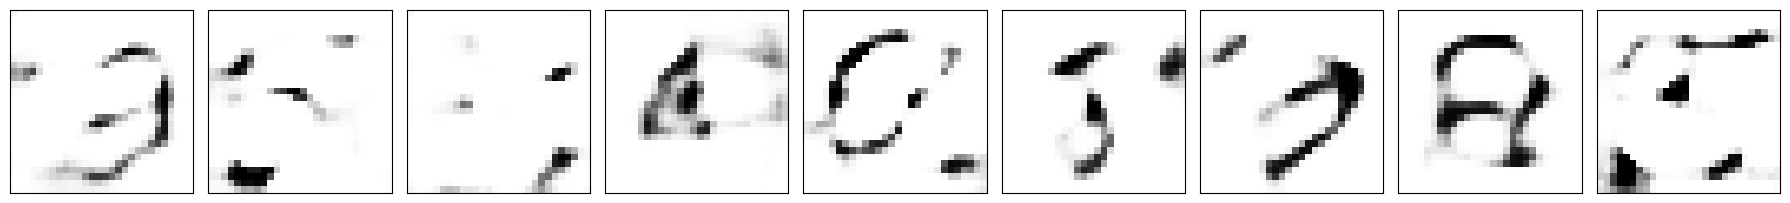

In [131]:
if mode == 'MONO':
    images = img_gen

    no_images = images.shape[0]

    plt.figure(figsize=(18, 3))
    no_rows = 1
    no_cols = no_images
    for img_idx in range(no_images):
        plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
        plt.imshow(images[img_idx, :, :, 0], cmap="binary")
        plt.xticks([])
        plt.yticks([])
    # Show the thing ...
    plt.tight_layout()
    plt.show()

## Anomaly detector

In [132]:
#Train on missing Data

anomaly_data = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train_anom, y_train_anom = anomaly_data.get_full_data_set(training=True)
x_test_anom, y_test_anom = anomaly_data.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_anom_R = x_train_anom[:, :, :, [0]]
x_test_anom_R = x_test_anom[:, :, :, [0]]

In [133]:
full_data = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = full_data.get_full_data_set(training=True)
x_test, y_test = full_data.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_R = x_train[:, :, :, [0]]
x_test_R = x_test[:, :, :, [0]]

In [134]:
x_test.shape

(10000, 28, 28, 1)

In [135]:
history = ae_anomally.fit(x_train_anom_R, x_train_anom_R,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (x_test_anom_R, x_test_anom_R),
)

Epoch 1/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 60s 111ms/step - loss: 0.0558 - val_loss: 0.0562
Epoch 2/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - loss: 0.0501 - val_loss: 0.0551
Epoch 3/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.0483 - val_loss: 0.0536
Epoch 4/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.0465 - val_loss: 0.0553
Epoch 5/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - loss: 0.0455 - val_loss: 0.0535


In [136]:
# Test on all data and check loss for each data

#from keras.losses import binary_crossentropy

# Prédire avec l'autoencodeur
no_channels = x_test.shape[-1]

reconstructions = np.zeros(x_test.shape)
for channel in range(no_channels):
    data = ae_anomally.predict(x_test[:, :, :, [channel]])
    reconstructions[:, :, :, channel] = data.squeeze()  # squeeze() to delete 1 dimension 

print(reconstructions.shape, x_test.shape)

# Calculer la perte entre les données originales et les reconstructions

if no_channels > 1:
    losses = np.mean(np.square(x_test - reconstructions), axis=(1, 2, 3))
else:
    losses = np.mean(np.square(x_test - reconstructions), axis=(1, 2))

losses = losses.squeeze()
# Récupérer les indices des données pour lesquelles la perte est maximale
max_loss_indices = np.argsort(losses)[-9:]
print(max_loss_indices)

# Récupérer les données pour lesquelles la perte est maximale
data_with_max_loss = x_test[max_loss_indices]
labels = y_test[max_loss_indices]
encoded_data = reconstructions[max_loss_indices]


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
(10000, 28, 28, 1) (10000, 28, 28, 1)
[4140 1859  631 4117 5888 9596 8330 1782 9750]


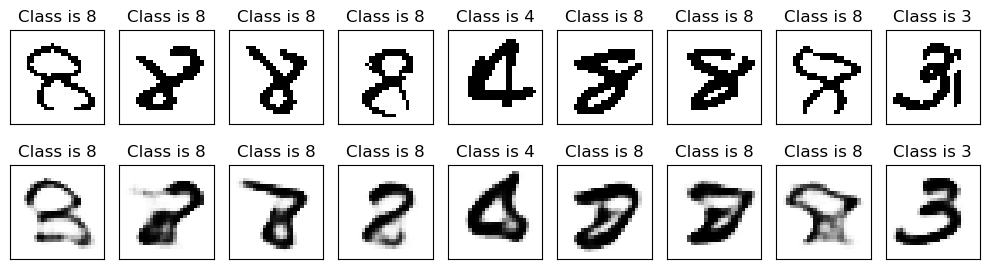

In [137]:
# Get data where loss is max, plot it and see if it is only eights
images = np.concatenate((data_with_max_loss, encoded_data), axis = 0)
labels = np.concatenate((labels, labels), axis = 0)

no_images = images.shape[0]

plt.figure(figsize=(10, 3))
no_rows = 2
no_cols = no_images//no_rows
for img_idx in range(no_images):
    plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
    if x_test.shape[-1] == 1:
        plt.imshow(images[img_idx, :, :, 0], cmap="binary")
    else:
        plt.imshow(images[img_idx, :, :, :].astype(float))
    plt.title(f"Class is {str(int(labels[img_idx])).zfill(x_test.shape[-1])}")
    plt.xticks([])
    plt.yticks([])
# Show the thing ...
plt.tight_layout()
plt.show()

In [138]:
# Pour stacked mean, construire une loss personnalisée qui est la moyenne de la loss sur chaque channel